In [ ]:
pip install datasets transformers umap-learn

In [2]:
from datasets import list_datasets, load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pprint as pp
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
all_datasets = list_datasets()
len(all_datasets)
all_datasets[:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [4]:
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
print(len(train_ds))
print(train_ds[0])

16000
{'text': 'i didnt feel humiliated', 'label': 0}


In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
print(train_ds['text'][:10])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy', 'ive been feeling a little burdened lately wasnt sure why that was', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'i feel as confused about life as a teenager or as jaded as a year old man', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'i feel romantic too']


In [11]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

In [12]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


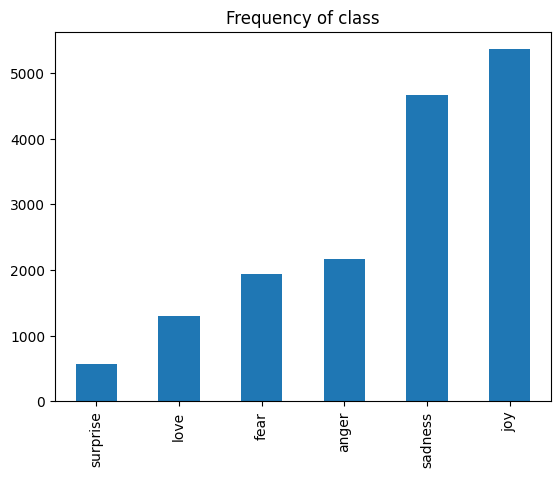

In [14]:
df['label_name'].value_counts(ascending=True).plot.bar()
plt.title('Frequency of class')
plt.show()

In [15]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


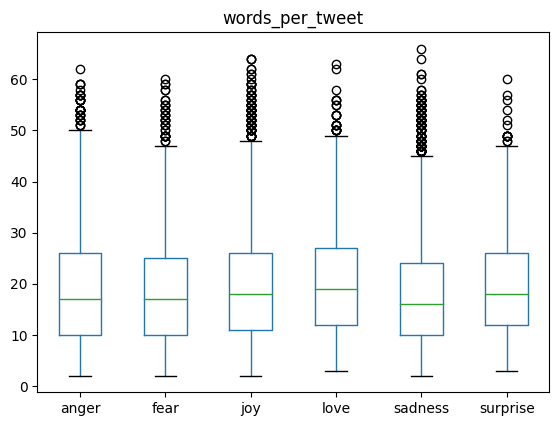

In [16]:
df.boxplot('words_per_tweet', by='label_name', grid=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokenizations

In [17]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [18]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [19]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [20]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [21]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [24]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [25]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

emotions.reset_format()
pp.pprint(tokenize(emotions['train'][:2]))

{'attention_mask': [[1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0],
                    [1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
                     1,
               

In [26]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


In [55]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [56]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
inputs['input_ids'].shape  # [ batch size, num tokens ]

torch.Size([1, 6])

In [57]:
inputs = {k: v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)

print(outputs.logits.shape)
print(outputs.last_hidden_state.shape) # batch size, tokens, vector size of each tokens

AttributeError: ignored

In [30]:
outputs.last_hidden_state[:, 0, :].shape

torch.Size([1, 768])

In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [32]:
def extract_hidden_states(batch):
  inputs = {k: v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Reutrn vector for [CLS] token by converting it to numpy array in cpu
  return {'hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

In [33]:
emotions_encoded.set_format('torch', 
                            columns=["input_ids", "attention_mask", "label"])

emotions_hidden_state = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
emotions_hidden_state['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [35]:
X_train = emotions_hidden_state['train']['hidden_state']
X_valid = emotions_hidden_state['validation']['hidden_state']
y_train = emotions_hidden_state['train']['label']
y_valid = emotions_hidden_state['validation']['label']
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([16000, 768]),
 torch.Size([2000, 768]),
 torch.Size([16000]),
 torch.Size([2000]))

In [36]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.522874,6.197266,0
1,-2.836965,5.777213,0
2,5.537283,2.740063,3
3,-2.161996,3.342881,2
4,-3.111819,3.678316,3


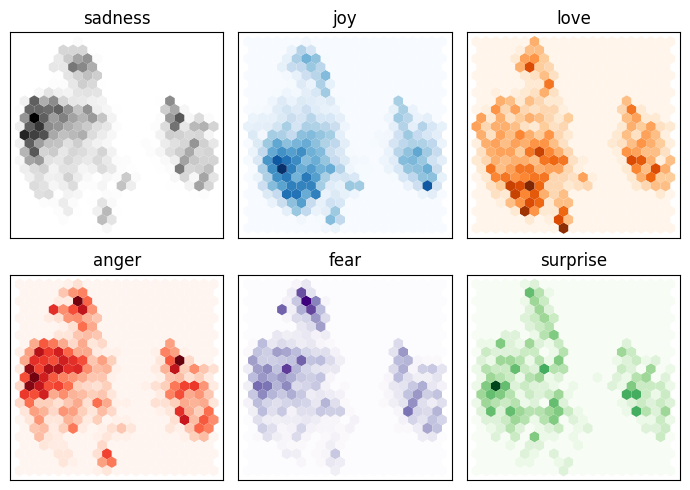

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [38]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [39]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Purples', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized Confusion Matrix')
  plt.show()

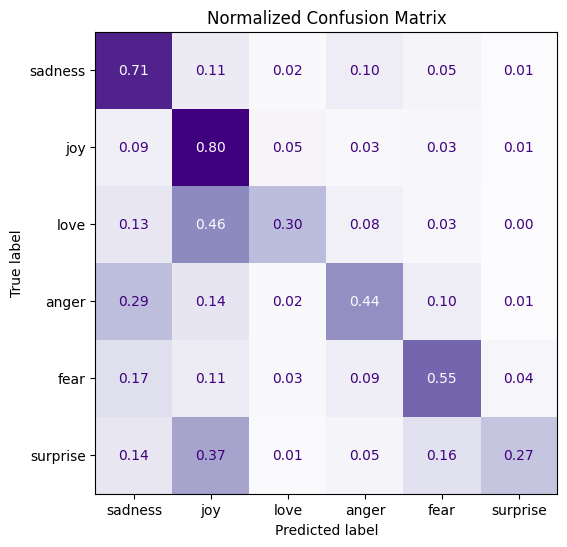

In [40]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine Tuning transformers

In [63]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

In [64]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [65]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
          num_train_epochs=2,
          learning_rate=2e-5,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          weight_decay=0.01,
          evaluation_strategy="epoch",
          disable_tqdm=False,
          logging_steps=logging_steps,
          push_to_hub=False,
          log_level="error")

In [66]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833500,0.308243,0.903000,0.899731
2,0.250300,0.216304,0.924000,0.924042


In [59]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

PredictionOutput(predictions=array([[ 4.763081  , -0.38926283, -1.0046767 , -0.81925654, -0.769759  ,
        -1.6699214 ],
       [ 4.733697  , -0.67165554, -1.5448316 , -0.5547726 , -0.41096762,
        -1.5694137 ],
       [-1.3490827 ,  1.781579  ,  2.8022292 , -0.9969897 , -1.6293219 ,
        -1.6289419 ],
       ...,
       [-0.9343426 ,  4.5570855 , -0.15459703, -1.1177388 , -1.3147085 ,
        -1.0524886 ],
       [-1.896501  ,  2.4015765 ,  2.6850286 , -1.3384861 , -1.6936812 ,
        -1.243066  ],
       [-1.417651  ,  4.3655405 ,  0.40245047, -1.5710963 , -1.3619052 ,
        -0.581794  ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.21406076848506927, 'test_accuracy': 0.9225, 'test_f1': 0.9225732206885588, 'test_runtime': 3.6434, 'test_samples_per_second': 548.938, 'test_steps_per_second': 8.783})

In [46]:
preds_output.metrics

{'test_loss': 0.21406076848506927,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225732206885588,
 'test_runtime': 3.6836,
 'test_samples_per_second': 542.944,
 'test_steps_per_second': 8.687}

In [58]:
preds_output.predictions.shape

(2000, 6)

In [48]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 0, 2, ..., 1, 2, 1])

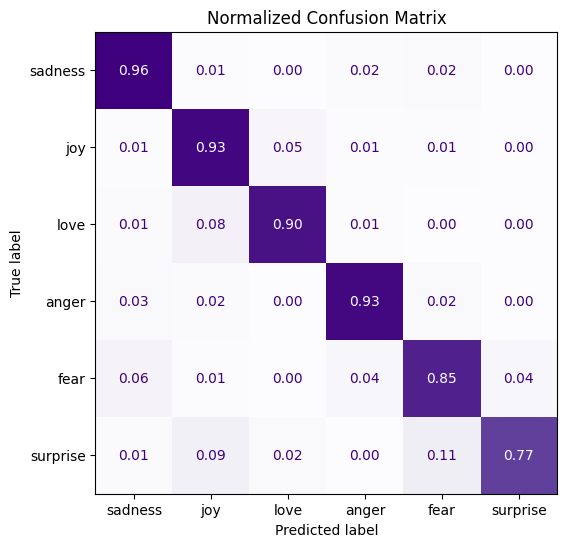

In [49]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [82]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  inputs = {k: v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}



In [67]:
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])

In [72]:
testing = emotions_encoded["validation"][:5]

In [83]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [85]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]

In [87]:
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
.apply(label_int2str))

In [88]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.654256
1274,i am going to several holiday parties and i ca...,joy,sadness,5.300449
882,i feel badly about reneging on my commitment t...,love,sadness,5.291811
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.263168
1963,i called myself pro life and voted for perry w...,joy,sadness,5.219435
765,i feel super awkward and out of place right now,joy,sadness,5.021716
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.987484
405,i have been feeling extraordinarily indecisive...,fear,joy,4.842459
465,i would eventually go in to these stores but i...,joy,fear,4.612288
1111,im lazy my characters fall into categories of ...,joy,fear,4.423117


In [89]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.015473
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.015798
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.015803
571,i realize that i sound a little overdramatic w...,sadness,sadness,0.015880
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.016072
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.016090
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.016098
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.016142
69,i have no extra money im worried all of the ti...,sadness,sadness,0.016187
657,i don t know when i will want to tell her and ...,sadness,sadness,0.016275
